In [1]:
import pandas as pd

In [2]:
# posts_df
# Data columns (total 9 columns):
# #   Column            Dtype 
# ---  ------            -----
# 0   post_id           object
# 1   thread_id         object
# 2   user_id           int64
# 3   text              object
# 4   reposts_count     int64
# 5   likes_count       int64
# 6   comments_count    int64
# 7   parent_thread_id  object
# 8   timestamp         int64


# unique_users_df
# Data columns (total 7 columns):
# #   Column              Dtype 
# ---  ------              -----
# 0   user_id             int64
# 1   username            object
# 2   friends_count       int64
# 3   followers_count     int64
# 4   bi_followers_count  int64
# 5   user_created_at     int64
# 6   last_activity       int64 
users_df = pd.read_csv("../../dataset_zip/weibo_users_df.csv")

# labelled_posts_df
# Data columns (total 11 columns):
# #   Column            Non-Null Count  Dtype 
# ---  ------            --------------  -----
# 0   post_id           4718 non-null   object
# 1   label             4718 non-null   object
# 2   children          4718 non-null   object
# 3   thread_id         4718 non-null   object
# 4   user_id           4718 non-null   int64
# 5   text              4718 non-null   object
# 6   reposts_count     4718 non-null   int64
# 7   likes_count       4718 non-null   int64
# 8   comments_count    4718 non-null   int64
# 9   parent_thread_id  54 non-null     object
# 10  timestamp         4718 non-null   int64 
posts_df = pd.read_csv("../../dataset_zip/weibo_posts_merged_df.csv")


In [3]:
import re
import jieba

def clean_text(text):
    # Remove non-Chinese characters (keep Chinese, numbers, and basic punctuation)
    text = re.sub(r"[^\u4e00-\u9fffA-Za-z0-9,，.!?！？]", "", text)
    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

def segment_text(text):
    # Segment text using jieba
    words = jieba.lcut(text)
    # Join words back with spaces (useful for embeddings)
    return ' '.join(words)

# Load a list of Chinese stop words
with open('../../dataset_zip/cn_stopwords.txt', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

In [4]:
posts_df['cleaned_text'] = posts_df['text'].fillna("").apply(clean_text)
posts_df['segmented_text'] = posts_df['cleaned_text'].apply(segment_text)
posts_df['final_text'] = posts_df['segmented_text'].apply(remove_stopwords)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Loading model cost 0.460 seconds.
Prefix dict has been built successfully.


In [5]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Prepare tagged documents
documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(posts_df['final_text'])]
# Train the Doc2Vec model
model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4)

# Add embeddings to the DataFrame
posts_df['text_embeddings'] = posts_df['final_text'].apply(lambda x: model.infer_vector(x.split()))


In [6]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Normalize engagement counts
scaler = MinMaxScaler()
posts_df[['reposts_count', 'likes_count', 'comments_count']] = scaler.fit_transform(
    posts_df[['reposts_count', 'likes_count', 'comments_count']]
)

# Extract time features
posts_df['hour'] = pd.to_datetime(posts_df['timestamp'], unit='s').dt.hour
posts_df['day'] = pd.to_datetime(posts_df['timestamp'], unit='s').dt.day
posts_df['month'] = pd.to_datetime(posts_df['timestamp'], unit='s').dt.month

In [7]:
users_df[['friends_count', 'followers_count', 'bi_followers_count']] = scaler.fit_transform(
    users_df[['friends_count', 'followers_count', 'bi_followers_count']]
)


In [8]:
merged_df = posts_df.merge(users_df, on='user_id', how='left')


In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from resnet18Model import CSIModelWithResNet
import matplotlib.pyplot as plt

# Prepare data
X_text = np.stack(merged_df['text_embeddings'].values)
X_user = merged_df[['friends_count', 'followers_count', 'bi_followers_count']].values
y = (merged_df['label']).astype(int).values  # Convert labels to binary

# Apply PCA to reduce dimensions of text embeddings
print("Applying PCA on Text Embeddings...")
pca = PCA(n_components=10)  # Choose the number of components
X_text_pca = pca.fit_transform(X_text)

# Custom Dataset class
class CSIDataset(Dataset):
    def __init__(self, text_data, user_data, labels):
        self.text_data = text_data
        self.user_data = user_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.text_data[idx], dtype=torch.float32)
        user = torch.tensor(self.user_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return text, user, label

class CombinedBCELossWithFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, focal_weight=0.5):
        """
        Combined Binary Cross-Entropy Loss and Focal Loss
        :param alpha: Weighting factor for focal loss (default 1)
        :param gamma: Focusing parameter for focal loss (default 2)
        :param focal_weight: The weight of focal loss in the combination
        """
        super(CombinedBCELossWithFocalLoss, self).__init__()
        self.bce = nn.BCELoss()  # Binary Cross-Entropy Loss
        self.alpha = alpha
        self.gamma = gamma
        self.focal_weight = focal_weight

    def forward(self, inputs, targets):
        # BCE Loss
        bce_loss = self.bce(inputs, targets)

        # Focal Loss
        pt = torch.sigmoid(inputs)  # Probabilities for Focal Loss
        pt = torch.clamp(pt, 1e-7, 1 - 1e-7)  # Avoid log(0) instability
        focal_loss = self.alpha * (1 - pt) ** self.gamma * targets * torch.log(pt) + \
                     (1 - self.alpha) * pt ** self.gamma * (1 - targets) * torch.log(1 - pt)
        focal_loss = -focal_loss.mean()

        # Combine the two losses
        combined_loss = (1 - self.focal_weight) * bce_loss + self.focal_weight * focal_loss
        return combined_loss

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Hyperparameters
text_embedding_dim = X_text_pca.shape[1]  # Updated to the PCA output dimensions
user_feature_dim = X_user.shape[1]
lstm_hidden_dim = 32
fc_hidden_dim = 16
learning_rate = 0.001 #0.001
num_epochs = 120
k_folds = 5
batch_size = 32

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=32)

# Loss function
criterion = CombinedBCELossWithFocalLoss(alpha=0.8, gamma=2, focal_weight=0.5)

# Store fold results
fold_results = []
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_text_pca)):
    print(f"\nFold {fold + 1}/{k_folds}")

    # Split data into training and validation sets
    train_text = X_text_pca[train_idx]
    train_user = X_user[train_idx]
    train_labels = y[train_idx]

    val_text = X_text_pca[val_idx]
    val_user = X_user[val_idx]
    val_labels = y[val_idx]

    # Create DataLoaders for training and validation sets
    train_dataset = CSIDataset(train_text, train_user, train_labels)
    val_dataset = CSIDataset(val_text, val_user, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = CSIModelWithResNet(text_embedding_dim, user_feature_dim, lstm_hidden_dim, fc_hidden_dim)
    model.to(device)

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


    # Training and Validation
    training_losses = []
    validation_losses = []
    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress", unit="epoch"):
        model.train()
        total_train_loss = 0

        for text_batch, user_batch, labels_batch in train_loader:
            text_batch = text_batch.unsqueeze(1)
            text_batch, user_batch, labels_batch = (
                text_batch.to(device),
                user_batch.to(device),
                labels_batch.to(device),
            )

            optimizer.zero_grad()
            outputs = model(text_batch, user_batch).squeeze()
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        # print("Text Batch Shape:", text_batch.shape)  # Should be 3D (batch_size, seq_len, input_size)
        # print("User Features Shape:", user_batch.shape)  
        # print("Text Embeddings Shape:", text_embeddings.shape)  # Should be 3D (batch_size, seq_len, input_size)
        # print("User Features Shape (Before ResNet):", user_features.shape) 
           
        # Validation
        model.eval()
        total_val_loss = 0
        val_labels_list = []
        val_preds_list = []
        with torch.no_grad():
            for text_batch, user_batch, labels_batch in val_loader:
                text_batch = text_batch.unsqueeze(1)
                text_batch, user_batch, labels_batch = (
                    text_batch.to(device),
                    user_batch.to(device),
                    labels_batch.to(device),
                )
                outputs = model(text_batch, user_batch).squeeze()
                loss = criterion(outputs, labels_batch)
                total_val_loss += loss.item()

                # Collect predictions and labels for metrics
                val_labels_list.extend(labels_batch.cpu().numpy())
                val_preds_list.extend((outputs > 0.5).cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        # Update Scheduler 
        scheduler.step()

        # Print every 10 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Calculate metrics for the fold
    accuracy = accuracy_score(val_labels_list, val_preds_list)
    precision = precision_score(val_labels_list, val_preds_list)
    recall = recall_score(val_labels_list, val_preds_list)
    f1 = f1_score(val_labels_list, val_preds_list)
    roc_auc = roc_auc_score(val_labels_list, val_preds_list)
    print(f"Fold {fold + 1} Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

    # Store fold metrics
    fold_metrics.append({
        "fold": fold + 1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
    })

# Average results across folds
average_metrics = {
    key: np.mean([fold[key] for fold in fold_metrics])
    for key in fold_metrics[0] if key != "fold"
}
print("\nAverage Metrics Across All Folds")
for metric, value in average_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Applying PCA on Text Embeddings...
cuda

Fold 1/5


Training Progress:   0%|          | 0/120 [00:00<?, ?epoch/s]

Training Progress:  77%|███████▋  | 92/120 [08:26<02:34,  5.50s/epoch]


KeyboardInterrupt: 

In [10]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from resnet18Model import CSIModelWithResNet

# Prepare data
X_text = np.stack(merged_df['text_embeddings'].values)
X_user = merged_df[['friends_count', 'followers_count', 'bi_followers_count']].values
y = (merged_df['label']).astype(int).values  # Convert labels to binary

# Custom Dataset class
class CSIDataset(Dataset):
    def __init__(self, text_data, user_data, labels):
        self.text_data = text_data
        self.user_data = user_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.text_data[idx], dtype=torch.float32)
        user = torch.tensor(self.user_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return text, user, label

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Hyperparameters
user_feature_dim = X_user.shape[1]
lstm_hidden_dim = 32
fc_hidden_dim = 16
learning_rate = 0.001
num_epochs = 120
k_folds = 5
batch_size = 32

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=32)

# Loss function
criterion = nn.BCELoss()

# Store results for each PCA value
pca_results = []

# Range of PCA components to evaluate
pca_values = range(2, 21)

for n_components in pca_values:
    print(f"\nEvaluating PCA with {n_components} components...")
    
    # Apply PCA to reduce dimensions of text embeddings
    pca = PCA(n_components=n_components)
    X_text_pca = pca.fit_transform(X_text)
    
    # Store fold metrics
    fold_metrics = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_text_pca)):
        print(f"\nFold {fold + 1}/{k_folds}")

        # Split data into training and validation sets
        train_text = X_text_pca[train_idx]
        train_user = X_user[train_idx]
        train_labels = y[train_idx]

        val_text = X_text_pca[val_idx]
        val_user = X_user[val_idx]
        val_labels = y[val_idx]

        # Create DataLoaders for training and validation sets
        train_dataset = CSIDataset(train_text, train_user, train_labels)
        val_dataset = CSIDataset(val_text, val_user, val_labels)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize the model
        model = CSIModelWithResNet(n_components, user_feature_dim, lstm_hidden_dim, fc_hidden_dim)
        model.to(device)

        # Optimizer
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

        # Training and Validation
        for epoch in tqdm(range(1, num_epochs + 1), desc=f"Training Progress for PCA {n_components}", unit="epoch"):
            model.train()
            for text_batch, user_batch, labels_batch in train_loader:
                text_batch = text_batch.unsqueeze(1)
                text_batch, user_batch, labels_batch = (
                    text_batch.to(device),
                    user_batch.to(device),
                    labels_batch.to(device),
                )

                optimizer.zero_grad()
                outputs = model(text_batch, user_batch).squeeze()
                loss = criterion(outputs, labels_batch)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        val_labels_list = []
        val_preds_list = []
        with torch.no_grad():
            for text_batch, user_batch, labels_batch in val_loader:
                text_batch = text_batch.unsqueeze(1)
                text_batch, user_batch, labels_batch = (
                    text_batch.to(device),
                    user_batch.to(device),
                    labels_batch.to(device),
                )
                outputs = model(text_batch, user_batch).squeeze()
                val_labels_list.extend(labels_batch.cpu().numpy())
                val_preds_list.extend((outputs > 0.5).cpu().numpy())

        # Calculate metrics for the fold
        accuracy = accuracy_score(val_labels_list, val_preds_list)
        precision = precision_score(val_labels_list, val_preds_list)
        recall = recall_score(val_labels_list, val_preds_list)
        f1 = f1_score(val_labels_list, val_preds_list)
        roc_auc = roc_auc_score(val_labels_list, val_preds_list)

        fold_metrics.append({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
        })

    # Average metrics across folds for this PCA value
    average_metrics = {
        key: np.mean([fold[key] for fold in fold_metrics])
        for key in fold_metrics[0]
    }
    print(f"\nAverage Metrics for PCA {n_components}: {average_metrics}")
    pca_results.append((n_components, average_metrics))

# Identify the best PCA value based on F1 score
best_pca_value = max(pca_results, key=lambda x: x[1]['f1'])
print(f"\nBest PCA value: {best_pca_value[0]} with metrics: {best_pca_value[1]}")

# Plot metrics for each PCA value
f1_scores = [result[1]['f1'] for result in pca_results]
plt.figure(figsize=(8, 6))
plt.plot(pca_values, f1_scores, marker='o', label="F1 Score")
plt.xlabel("Number of PCA Components")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Number of PCA Components")
plt.legend()
plt.show()


cuda

Evaluating PCA with 2 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 2: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 2/5


Training Progress for PCA 2: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 3/5


Training Progress for PCA 2: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 2: 100%|██████████| 120/120 [10:01<00:00,  5.02s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 2: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Average Metrics for PCA 2: {'accuracy': 0.8929597210489423, 'precision': 0.8919446609996646, 'recall': 0.8888036256713228, 'f1': 0.8898159786750067, 'roc_auc': 0.8928619189675586}

Evaluating PCA with 3 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 3: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 2/5


Training Progress for PCA 3: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]



Fold 3/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 3: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Fold 4/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 3: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 5/5


Training Progress for PCA 3: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Average Metrics for PCA 3: {'accuracy': 0.9050422830131029, 'precision': 0.8894371041227809, 'recall': 0.9209640674611753, 'f1': 0.9046640772804446, 'roc_auc': 0.9054241061495825}

Evaluating PCA with 4 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 4: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 2/5


Training Progress for PCA 4: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 3/5


Training Progress for PCA 4: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 4: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 4: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]



Average Metrics for PCA 4: {'accuracy': 0.9118253140895447, 'precision': 0.8874360343081544, 'recall': 0.9386375815984052, 'f1': 0.9122219390508466, 'roc_auc': 0.9121159332317926}

Evaluating PCA with 5 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 5: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 2/5


Training Progress for PCA 5: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 3/5


Training Progress for PCA 5: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 5: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 5: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]



Average Metrics for PCA 5: {'accuracy': 0.9067369735967071, 'precision': 0.900400150632011, 'recall': 0.9103942979263338, 'f1': 0.9050796635816459, 'roc_auc': 0.9071859627269305}

Evaluating PCA with 6 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 6: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 2/5


Training Progress for PCA 6: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 3/5


Training Progress for PCA 6: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 6: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 6: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Average Metrics for PCA 6: {'accuracy': 0.9048290705825259, 'precision': 0.8939484408527353, 'recall': 0.9141348354320948, 'f1': 0.9036351583339768, 'roc_auc': 0.9048262784185466}

Evaluating PCA with 7 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 7: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]



Fold 2/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 7: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 3/5


Training Progress for PCA 7: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 7: 100%|██████████| 120/120 [10:00<00:00,  5.01s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 7: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]



Average Metrics for PCA 7: {'accuracy': 0.901227150996639, 'precision': 0.8984054973892028, 'recall': 0.902003624456216, 'f1': 0.8995051049959859, 'roc_auc': 0.9020524911897153}

Evaluating PCA with 8 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 8: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 2/5


Training Progress for PCA 8: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 3/5


Training Progress for PCA 8: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 8: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 8: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Average Metrics for PCA 8: {'accuracy': 0.8942324801840502, 'precision': 0.9037254505444509, 'recall': 0.8779936457704547, 'f1': 0.8898234133396533, 'roc_auc': 0.8931588708421637}

Evaluating PCA with 9 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 9: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 2/5


Training Progress for PCA 9: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Fold 3/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 9: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/tor


Fold 4/5


Training Progress for PCA 9: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 9: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]



Average Metrics for PCA 9: {'accuracy': 0.9088574150295667, 'precision': 0.9025381592094615, 'recall': 0.9128255862434734, 'f1': 0.9072611060361531, 'roc_auc': 0.9086567060813323}

Evaluating PCA with 10 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 10: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/to


Fold 2/5


Training Progress for PCA 10: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 3/5


Training Progress for PCA 10: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 10: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 10: 100%|██████████| 120/120 [10:01<00:00,  5.01s/epoch]



Average Metrics for PCA 10: {'accuracy': 0.9039809389435088, 'precision': 0.9063798008528738, 'recall': 0.8983379347913545, 'f1': 0.9014964858402459, 'roc_auc': 0.9047888116209097}

Evaluating PCA with 11 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 11: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/to


Fold 2/5


Training Progress for PCA 11: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]



Fold 3/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 11: 100%|██████████| 120/120 [10:00<00:00,  5.01s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/to


Fold 4/5


Training Progress for PCA 11: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 11: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]



Average Metrics for PCA 11: {'accuracy': 0.9080126534500422, 'precision': 0.8990527561053984, 'recall': 0.9164029927099548, 'f1': 0.9070756891619253, 'roc_auc': 0.9089778475197436}

Evaluating PCA with 12 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 12: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Fold 2/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 12: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/to


Fold 3/5


Training Progress for PCA 12: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Fold 4/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 12: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/to


Fold 5/5


Training Progress for PCA 12: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Average Metrics for PCA 12: {'accuracy': 0.9111888221866744, 'precision': 0.904250520005337, 'recall': 0.9160583563489398, 'f1': 0.909816206671023, 'roc_auc': 0.9116135876831141}

Evaluating PCA with 13 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 13: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/to


Fold 2/5


Training Progress for PCA 13: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 3/5


Training Progress for PCA 13: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 13: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 13: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]



Average Metrics for PCA 13: {'accuracy': 0.9041923540090228, 'precision': 0.9032162410070382, 'recall': 0.8999091060136214, 'f1': 0.9014077023409917, 'roc_auc': 0.9034351780093666}

Evaluating PCA with 14 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 14: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/to


Fold 2/5


Training Progress for PCA 14: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 3/5


Training Progress for PCA 14: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 14: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 14: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]



Average Metrics for PCA 14: {'accuracy': 0.9046181048582778, 'precision': 0.8999723806932499, 'recall': 0.9078335926482486, 'f1': 0.9029057554597631, 'roc_auc': 0.9053278998129969}

Evaluating PCA with 15 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 15: 100%|██████████| 120/120 [10:00<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/to


Fold 2/5


Training Progress for PCA 15: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 3/5


Training Progress for PCA 15: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 4/5


Training Progress for PCA 15: 100%|██████████| 120/120 [09:59<00:00,  5.00s/epoch]
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Fold 5/5


Training Progress for PCA 15: 100%|██████████| 120/120 [09:59<00:00,  4.99s/epoch]



Average Metrics for PCA 15: {'accuracy': 0.911611876988335, 'precision': 0.9075419699594647, 'recall': 0.9120345794167891, 'f1': 0.9095886777253362, 'roc_auc': 0.9111834811434495}

Evaluating PCA with 16 components...

Fold 1/5


/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vnandak/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress for PCA 16:  50%|█████     | 60/120 [05:00<04:59,  5.00s/epoch]


Class Distribution in Fold 3:
Class 0: 472 samples (50.05%)
Class 1: 471 samples (49.95%)


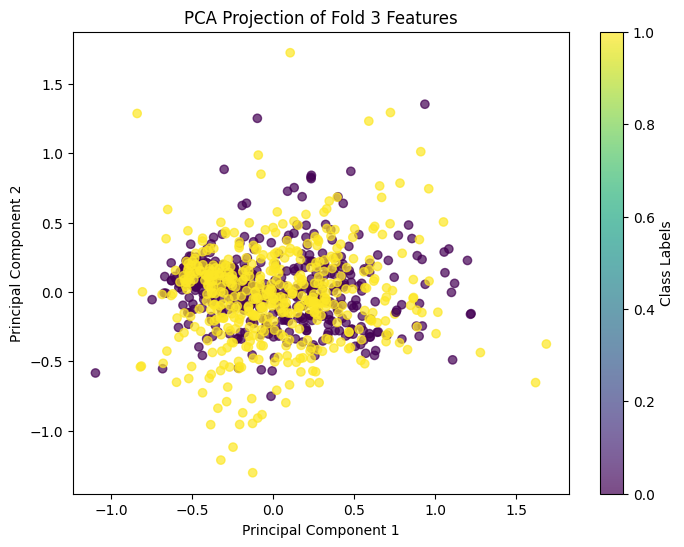

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Extract Fold 3 data
fold_3_text = X_text_pca[val_idx]  # Text embeddings for Fold 3
fold_3_user = X_user[val_idx]  # User features for Fold 3
fold_3_labels = y[val_idx]  # Labels for Fold 3

# Check class distribution
class_distribution = Counter(fold_3_labels)
total_samples = len(fold_3_labels)

print("\nClass Distribution in Fold 3:")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples ({(count / total_samples) * 100:.2f}%)")

# Visualize Fold 3 outliers using PCA
pca_fold_3 = PCA(n_components=2)
reduced_features = pca_fold_3.fit_transform(fold_3_text)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=fold_3_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Class Labels")
plt.title("PCA Projection of Fold 3 Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()




Cumulative Explained Variance by PCA Components:
Component 1: 45.80%
Component 2: 70.14%
Component 3: 84.68%
Component 4: 91.09%
Component 5: 94.33%
Component 6: 95.68%
Component 7: 96.63%
Component 8: 97.29%
Component 9: 97.83%
Component 10: 98.26%
Component 11: 98.57%
Component 12: 98.72%
Component 13: 98.84%
Component 14: 98.96%
Component 15: 99.05%
Component 16: 99.14%
Component 17: 99.20%
Component 18: 99.27%
Component 19: 99.32%
Component 20: 99.36%
Component 21: 99.40%
Component 22: 99.43%
Component 23: 99.47%
Component 24: 99.49%
Component 25: 99.52%
Component 26: 99.54%
Component 27: 99.57%
Component 28: 99.59%
Component 29: 99.61%
Component 30: 99.62%
Component 31: 99.64%
Component 32: 99.66%
Component 33: 99.67%
Component 34: 99.69%
Component 35: 99.70%
Component 36: 99.71%
Component 37: 99.72%
Component 38: 99.73%
Component 39: 99.74%
Component 40: 99.75%
Component 41: 99.76%
Component 42: 99.77%
Component 43: 99.77%
Component 44: 99.78%
Component 45: 99.79%
Component 46: 

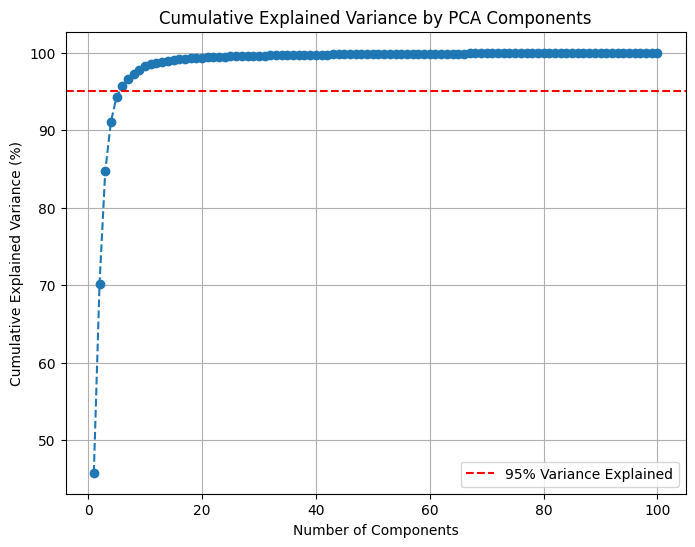


Optimal Number of PCA Components for 95% Variance: 6


In [ ]:
# Analyze Variance Explained by PCA Components
pca_full = PCA(n_components=X_text.shape[1])  # Use all components from the original dataset
pca_full.fit(X_text)

explained_variance = np.cumsum(pca_full.explained_variance_ratio_) * 100

print("\nCumulative Explained Variance by PCA Components:")
for i, variance in enumerate(explained_variance):
    print(f"Component {i + 1}: {variance:.2f}%")

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.axhline(y=95, color='r', linestyle='--', label="95% Variance Explained")
plt.legend()
plt.grid()
plt.show()

# Adjust PCA components if less than desired variance is explained
desired_variance = 95  # Target percentage of variance
optimal_components = np.argmax(explained_variance >= desired_variance) + 1
print(f"\nOptimal Number of PCA Components for {desired_variance}% Variance: {optimal_components}")

# Re-apply PCA with optimal components
pca_adjusted = PCA(n_components=optimal_components)
X_text_pca_adjusted = pca_adjusted.fit_transform(X_text)


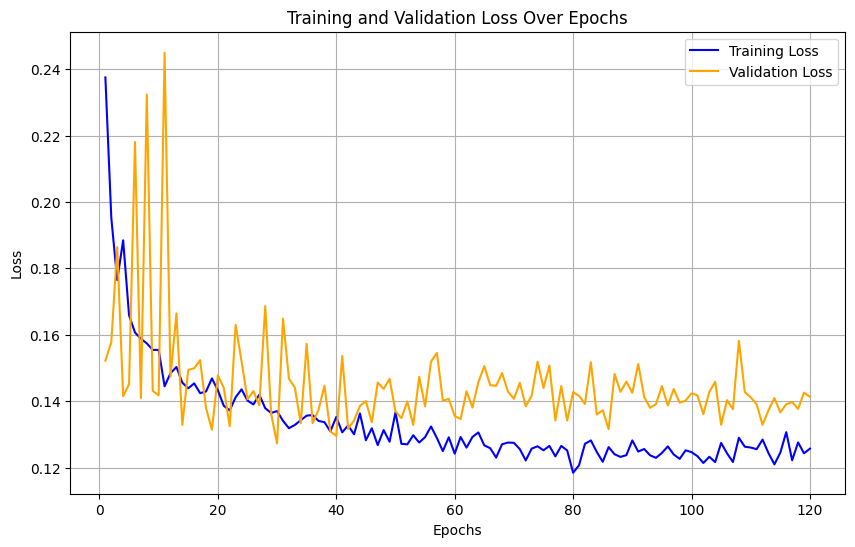

In [ ]:
# Plot losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()